# Quantization in TFLite
In this assignment you are tasked to quantize a model in TFLite. The model we are exploring today is a computer vision model that recognizes hand gestures for the rock, paper, scissors game!

### Import packages

In [ ]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass


Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


In [ ]:
import numpy as np
import matplotlib.pylab as plt
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds
from tqdm import tqdm
import pathlib

print("TensorFlow version:", tf.__version__)
print("TensorFlow Hub version:", hub.__version__)

TensorFlow version: 2.15.0
TensorFlow Hub version: 0.16.1


In [ ]:
#FIX ON ED:
#!pip install tensorflow==2.15

### Download the dataset

In the below cell, we load the rock_paper_scissors dataset. We define the dataset split such that the first 80% of the train split is loaded onto 'raw_train', and the remaining 20% is loaded onto 'raw_validation'. A separate test split is loaded onto 'raw_test'.

In [ ]:
SPLIT = ['train[:80%]', 'train[80%:]', 'test']

(raw_train, raw_validation, raw_test), metadata = tfds.load(
    'rock_paper_scissors', split=SPLIT,
    with_info=True, as_supervised=True)


print("Number of data samples:", metadata.splits['train'].num_examples)
print("Number of test data samples:", metadata.splits['test'].num_examples)
print("Number of classes:", metadata.features['label'].num_classes)

Number of data samples: 2520
Number of test data samples: 372
Number of classes: 3


---


**Question 1**: Do you notice a difference in how we define the split parameter in tfds.load() in this assignment compared to Tutorial 2.2? These links could help you - [Link1](https://www.tensorflow.org/datasets/api_docs/python/tfds/load), [Link2](https://www.tensorflow.org/datasets/splits).

**Answer:**  In Tutorial 2.2, we defined the split to be a 3-way split across the training data for our training, validation, and test sets. Here, we are splitting the training data into our training and validation sets before using a separate name-based split to define our test set.

---

### Visualize Training Examples

In the below cell, visualize a few raw training examples!

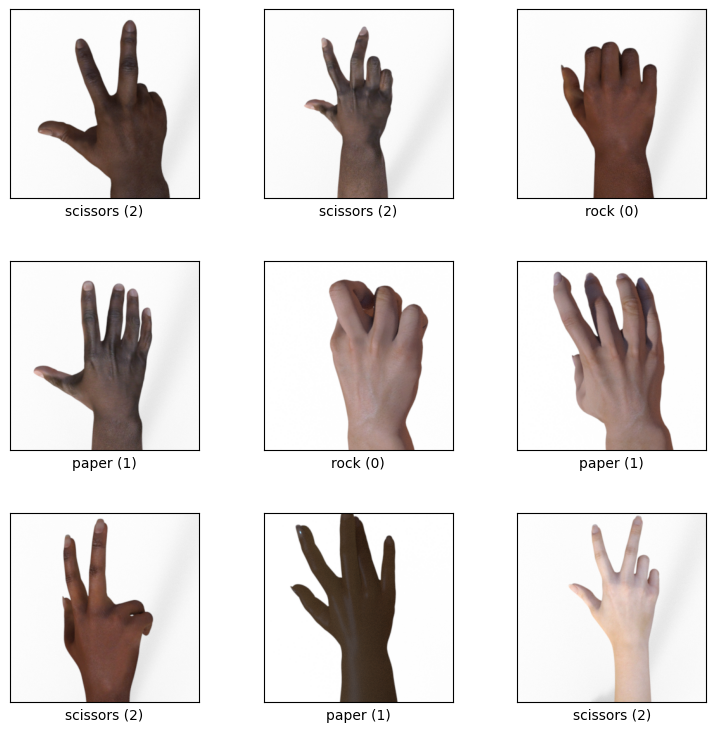

In [ ]:
# Visualize examples
vis = tfds.visualization.show_examples(raw_train, metadata)

We reshape the images to (224, 224, 3) and split the dataset into batches to reduce memory requirement.

In [ ]:
def format_image(image, label):
    image = tf.image.resize(image, (224, 224)) / 255.0
    return  image, label

BATCH_SIZE = 32
train_batches = raw_train.shuffle(metadata.splits['train'].num_examples // 4).map(format_image).batch(BATCH_SIZE).prefetch(1)
validation_batches = raw_validation.map(format_image).batch(BATCH_SIZE).prefetch(1)
test_batches = raw_test.map(format_image).batch(1)

### Define pre-trained model

Similar to what we did in Tutorial 2.2, we will use Transfer Learning to train our model. We will use the weights of a MobileNet model pre-trained on the ImageNet Dataset.

In [ ]:
module_selection = ("mobilenet_v2", 224, 1280)
handle_base, pixels, FV_SIZE = module_selection
MODULE_HANDLE ="https://tfhub.dev/google/tf2-preview/{}/feature_vector/4".format(handle_base)
IMAGE_SIZE = (pixels, pixels)
print("Using {} with input size {} and output dimension {}".format(MODULE_HANDLE, IMAGE_SIZE, FV_SIZE))


Using https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4 with input size (224, 224) and output dimension 1280


### Define your model

In the below cell, define your model. Use the feature extractor of the pre-trained mobilenet model as the initial layers. To complete your model, add layers to match the desired number of output classes.

Choose an appropriate Optimizer and Loss Function and compile your model.

In [ ]:
# Define and Compile model

#Define:
num_classes = metadata.features['label'].num_classes

feature_extractor = hub.KerasLayer(MODULE_HANDLE,
                                   input_shape=IMAGE_SIZE + (3,),
                                   output_shape=[FV_SIZE],
                                   trainable=False)

model = tf.keras.Sequential([
        feature_extractor,
        tf.keras.layers.Dense(num_classes, activation='softmax')
])


#Compile:
LOSS = 'sparse_categorical_crossentropy'
OPT = 'adam'


model.compile(optimizer=OPT,
                  loss=LOSS,
                  metrics=['accuracy'])

### Summarize your model



In [ ]:
# Summarize your model
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_2 (KerasLayer)  (None, 1280)              2257984   
                                                                 
 dense_2 (Dense)             (None, 3)                 3843      
                                                                 
Total params: 2261827 (8.63 MB)
Trainable params: 3843 (15.01 KB)
Non-trainable params: 2257984 (8.61 MB)
_________________________________________________________________


---


**Question 2**: Can you explain how we arrive at the number of parameters observed in the output layer of your above model?

**Answer:** Our feature extractor has output dimension 1280. We have 3 neurons in our dense/output layer (corresponding to the 3 classes) which are each connected to the previous 1280 neurons. They also each have their own biases. So, 3*1280+3 = 3843.

---

### Train your model

In the below cell, train your model! You can choose an arbitrary number of epochs.

In [ ]:
# Train your model
EPOCHS = 10

hist = model.fit(train_batches,
                 epochs=EPOCHS,
                 validation_data=validation_batches)

Epoch 1/10
63/63 [==============================] - 11s 86ms/step - loss: 0.3321 - accuracy: 0.9286 - val_loss: 0.0957 - val_accuracy: 0.9921
Epoch 2/10
63/63 [==============================] - 3s 44ms/step - loss: 0.0649 - accuracy: 0.9985 - val_loss: 0.0461 - val_accuracy: 1.0000
Epoch 3/10
63/63 [==============================] - 3s 46ms/step - loss: 0.0355 - accuracy: 0.9995 - val_loss: 0.0288 - val_accuracy: 1.0000
Epoch 4/10
63/63 [==============================] - 3s 47ms/step - loss: 0.0232 - accuracy: 1.0000 - val_loss: 0.0205 - val_accuracy: 1.0000
Epoch 5/10
63/63 [==============================] - 3s 45ms/step - loss: 0.0166 - accuracy: 1.0000 - val_loss: 0.0154 - val_accuracy: 1.0000
Epoch 6/10
63/63 [==============================] - 3s 45ms/step - loss: 0.0128 - accuracy: 1.0000 - val_loss: 0.0120 - val_accuracy: 1.0000
Epoch 7/10
63/63 [==============================] - 3s 46ms/step - loss: 0.0102 - accuracy: 1.0000 - val_loss: 0.0098 - val_accuracy: 1.0000
Epoch 8/10
6

### Plot Accuracy and Loss Graph

In the below cell, plot two graphs. **Plot 1** should contain both training and validation accuracies vs Epochs. **Plot 2** should contain both training and validation losses vs Epochs. Be sure to include a legend, title, and x & y axis labels.

***Hint:*** Use plt.subplots()

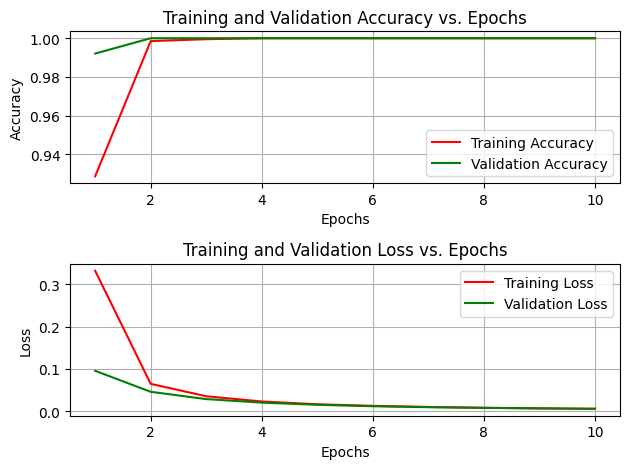

In [ ]:
# Plot accuracy and loss graphs for both the train and validation data sets.

xaxis = range(1, EPOCHS + 1)
fig, (ax1, ax2) = plt.subplots(2, 1)


#Plot 1:
ax1.plot(xaxis, hist.history['accuracy'], 'r', label='Training Accuracy')
ax1.plot(xaxis, hist.history['val_accuracy'], 'g', label='Validation Accuracy')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Accuracy')
ax1.set_title('Training and Validation Accuracy vs. Epochs')
ax1.legend(loc='lower right')
ax1.grid(True)

#Plot 2:
ax2.plot(xaxis, hist.history['loss'], 'r', label='Training Loss')
ax2.plot(xaxis, hist.history['val_loss'], 'g', label='Validation Loss')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Loss')
ax2.set_title('Training and Validation Loss vs. Epochs')
ax2.legend(loc='upper right')
ax2.grid(True)

plt.tight_layout()
plt.show()

### Save the Baseline model

We save the trained baseline model!

In [ ]:
ROCK_PAPER_SCISSORS_SAVED_MODEL = "saved_model"
tf.saved_model.save(model, ROCK_PAPER_SCISSORS_SAVED_MODEL)

### Model 1: Create a TensorFlow Lite model.

In the below cell, convert your Baseline TensorFlow model to a TensorFlow Lite model. **Save this model as 'model1.tflite'!**

***Hint:*** You'll need to use the saved model to generate a converter.

In [ ]:
# Convert to TFLite model
converter = tf.lite.TFLiteConverter.from_saved_model(ROCK_PAPER_SCISSORS_SAVED_MODEL)

tflite_model = converter.convert()

tflite_models_dir = pathlib.Path("/content/")
tflite_model_file = tflite_models_dir/'model1.tflite'
print("Size of model1:", tflite_model_file.write_bytes(tflite_model))

Size of model1: 8880424


### Model 2: Create a TensorFlow Lite model with Float-16 Quantization.

In the below cell, create a TensorFlow Lite model where the weights are converted from 'Float32' to 'Float16' values. **Save this model as 'model2.tflite'!**

In [ ]:
converter = tf.lite.TFLiteConverter.from_saved_model(ROCK_PAPER_SCISSORS_SAVED_MODEL)

converter.optimizations = [tf.lite.Optimize.DEFAULT]

converter.target_spec.supported_types = [tf.float16]

tflite_model = converter.convert()
tflite_models_dir = pathlib.Path("/content/")

tflite_model_file = tflite_models_dir/'model2.tflite'
tflite_model_file.write_bytes(tflite_model)
print("Size of model2:", tflite_model_file.write_bytes(tflite_model))

Size of model2: 4477892


---


**Question 3**: What do you observe about the size of model2 w.r.t model1?

**Answer:** model2 is smaller. It is about half the size of model1. This follows logically since we are essentially halving the number of bits representing each weight when converting from Float32 to Float16.

---

### Evaluation

In this section, we will evaluate both our TFLite models. What's the best way to run inference on Colab? Code it up in the cell below.

Predict the 'class label' for 100 test images. Report (a) the number of iterations/second and (b) the number of correct predictions for both model1.tflite and model2.tflite!

In [ ]:
# Run inference on both TFLite models

def evaluate_tflite_model(tflite_model_file):
  interpreter = tf.lite.Interpreter(model_path=tflite_model_file)
  interpreter.allocate_tensors()

  input_index = interpreter.get_input_details()[0]["index"]
  output_index = interpreter.get_output_details()[0]["index"]

  predictions = []
  test_labels, test_imgs = [], []
  for img, label in tqdm(test_batches.take(100)):
      interpreter.set_tensor(input_index, img)
      interpreter.invoke()
      predictions.append(interpreter.get_tensor(output_index))
      test_labels.append(label.numpy()[0])
      test_imgs.append(img)

  score = 0
  for item in range(0,100):
    prediction=np.argmax(predictions[item])
    label = test_labels[item]
    if prediction==label:
      score=score+1

  return score

In [ ]:
score_model_1 = evaluate_tflite_model('model1.tflite')
print("\nOut of 100 predictions I got " + str(score_model_1) + " correct")

100%|██████████| 100/100 [00:02<00:00, 38.75it/s]


Out of 100 predictions I got 83 correct


In [ ]:
score_model_2 = evaluate_tflite_model('model2.tflite')
print("\nOut of 100 predictions I got " + str(score_model_2) + " correct")

100%|██████████| 100/100 [00:01<00:00, 67.81it/s]


Out of 100 predictions I got 82 correct


## Plot Results

In this section, you can explore the results of both the models! It can help you visualize the images that the model predicts correct/incorrect.


In [ ]:
# Utilities for plotting

class_names = ['rock', 'paper', 'scissors']

def plot_image(i, predictions_array, true_label, img):
    predictions_array, true_label, img = predictions_array[i], true_label[i], img[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])

    img = np.squeeze(img)

    plt.imshow(img, cmap=plt.cm.binary)

    predicted_label = np.argmax(predictions_array)

    if predicted_label == true_label:
        color = 'green'
    else:
        color = 'red'

    plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                         100*np.max(predictions_array),
                                         class_names[true_label]), color=color)

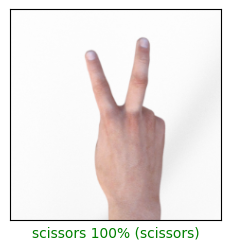

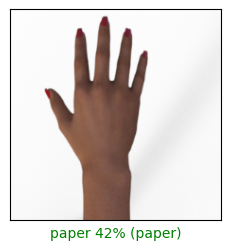

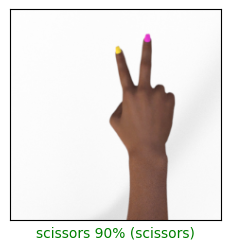

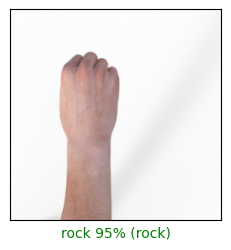

In [ ]:
#@title Visualize the outputs { run: "auto" }
max_index = 4 #@param {type:"slider", min:0, max:99, step:1}
for index in range(0,max_index):
  plt.figure(figsize=(6,3))
  plt.subplot(1,2,1)
  plot_image(index, predictions, test_labels, test_imgs)
  plt.show()



---



### **Additional Note**
Experiment with your model (no. of layers, optimizer, batch size etc.) and see if you can increase the number of correct predictions! **This is not graded!**